# Выбор локации для скважины для добывающей компании «ГлавРосГосНефть»

Для добывающей компании «ГлавРосГосНефть» необходимо решить, где бурить новую скважину.

**Шаги для выбора места скважины:**
* В избранном регионе ищут месторождения и собирают характеристики для скважин (качество нефти и объем ее запасов)
* Строят модель для предсказания объёма запасов в новых скважинах
* Выбирают скважины с самыми высокими оценками значений (количество месторождений зависит от бюджета компании и стоимости разработки одной скважины)
* Определяют регион с максимальной суммарной прибылью отобранных скважин

Заказчик предоставил пробы нефти в трех регионах - в каждом 10 000 месторождений, где измерили качество нефти и объем ее запасов.

**Условия задачи:**
* Для обучения модели подходит только линейная регрессия (остальные - недостаточно предсказуемые)
* При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки
* Бюджет на разработку скважин в регионе - 10 млрд рублей
* При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объем указан в тысячах баррелей.
* После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5% - среди них выбирают регион с наибольшей средней прибылью

**Цели исследования:**
* Построение модели машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль
* Анализ возможной прибыли и рисков техникой *Bootstrap*

**Ход исследования**

Данные для исследования будут получены из трех файлов. О качестве данных ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных. Необходимо будет проверить данные на ошибки и оценить их влияние на исследование. На этапе предобработки нужно осуществить поиск возможностей исправления всех ошибок данных, которые не приведут к искажению конечного результата. При необходимости, осуществим создание новых столбцов.

**Этапы исследования:**
1. Загрузка и обзор данных, подготовка данных к моделированию
2. Обучение и проверка моделей для каждого региона
3. Подготовка данных к расчету прибыли
4. Расчет прибыли и рисков по каждому региону, обоснование выбора региона
5. Написание общего вывода

## Загрузка и подготовка данных

### Загрузка данных

Установим и импортируем необходимые для исследования библиотеки:

In [1]:
!pip install phik -q

In [2]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
import matplotlib.pyplot as plt
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Откроем файлы с датасетом:

In [3]:
try:
    geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep=',', decimal='.')
except:
    geo_data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', sep=',', decimal='.')

In [4]:
try:
    geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep=',', decimal='.')
except:
    geo_data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', sep=',', decimal='.')

In [5]:
try:
    geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep=',', decimal='.')
except:
    geo_data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', sep=',', decimal='.')

In [6]:
dataframes = {
    'geo_data_0': geo_data_0,
    'geo_data_1': geo_data_1,
    'geo_data_2': geo_data_2
}

Определим функцию для отображения информации о датасете:

In [1]:
def get_info(df):
    display(df.head())
    print(50 * '-')
    print(df.info())
    print(50 * '-')
    display(df.describe().T)

Выведем первые строки, общую информацию и описательную статистику датасета `geo_data_0`:

In [8]:
get_info(geo_data_0)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347


Выведем первые строки, общую информацию и описательную статистику датасета `geo_data_1`:

In [9]:
get_info(geo_data_1)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408


Выведем первые строки, общую информацию и описательную статистику датасета `geo_data_2`:

In [10]:
get_info(geo_data_2)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
--------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838


Каждый файл содержит данные геологоразведки одного из трех регионов: 
* `id` - уникальный идентификатор скважины
* `f0`, `f1`, `f2` - признаки точек
* `product` - объем запасов в скважине (тыс. баррелей)

### Предобработка данных

Проверим датафреймы на наличие пропусков в данных:

In [11]:
for name, df in dataframes.items():
    print(f'{name}:')
    print(f'{df.isna().sum()}\n')

geo_data_0:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

geo_data_1:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

geo_data_2:
id         0
f0         0
f1         0
f2         0
product    0
dtype: int64



В датафреймах не обнаружены пропуски данных. Далее проверим датафреймы на наличие явных дубликатов:

In [12]:
for name, df in dataframes.items():
    print(f'{name} - {df.duplicated().sum()}')

geo_data_0 - 0
geo_data_1 - 0
geo_data_2 - 0


В датафреймах не обнаружены явные дубликаты.

Для каждого датафрейма произведем проверку столбца `id` на наличие дублей:

In [13]:
for name, df in dataframes.items():
    id = df.loc[df['id'].duplicated(), 'id'].values
    print(f'{name} ({id.size} дубл.)')
    for i in id:
        display(df.loc[df['id'] == i])
        print(55 * '-')
    print('\n')

geo_data_0 (10 дубл.)


,id,f0,f1,f2,product
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695


-------------------------------------------------------


,id,f0,f1,f2,product
1364,bxg6G,0.411645,0.856830,-3.653440,73.604260
41724,bxg6G,-0.823752,0.546319,3.630479,93.007798


-------------------------------------------------------


,id,f0,f1,f2,product
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205


-------------------------------------------------------


,id,f0,f1,f2,product
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675


-------------------------------------------------------


,id,f0,f1,f2,product
64022,74z30,0.741456,0.459229,5.153109,140.771492
66136,74z30,1.084962,-0.312358,6.990771,127.643327


-------------------------------------------------------


,id,f0,f1,f2,product
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453


-------------------------------------------------------


,id,f0,f1,f2,product
21426,Tdehs,0.829407,0.298807,-0.049563,96.035308
75715,Tdehs,0.112079,0.430296,3.218993,60.964018


-------------------------------------------------------


,id,f0,f1,f2,product
16633,fiKDv,0.157341,1.028359,5.585586,95.817889
90815,fiKDv,0.049883,0.841313,6.394613,137.346586


-------------------------------------------------------


,id,f0,f1,f2,product
60140,TtcGQ,0.569276,-0.104876,6.440215,85.350186
92341,TtcGQ,0.110711,1.022689,0.911381,101.318008


-------------------------------------------------------


,id,f0,f1,f2,product
89582,bsk9y,0.398908,-0.400253,10.122376,163.433078
97785,bsk9y,0.378429,0.005837,0.160827,160.637302


-------------------------------------------------------


geo_data_1 (4 дубл.)


,id,f0,f1,f2,product
1305,LHZR0,11.170835,-1.945066,3.002872,80.859783
41906,LHZR0,-8.989672,-4.286607,2.009139,57.085625


-------------------------------------------------------


,id,f0,f1,f2,product
2721,bfPNe,-9.494442,-5.463692,4.006042,110.992147
82178,bfPNe,-6.202799,-4.820045,2.995107,84.038886


-------------------------------------------------------


,id,f0,f1,f2,product
47591,wt4Uk,-9.091098,-8.109279,-0.002314,3.179103
82873,wt4Uk,10.259972,-9.376355,4.994297,134.766305


-------------------------------------------------------


,id,f0,f1,f2,product
5849,5ltQ6,-3.435401,-12.296043,1.999796,57.085625
84461,5ltQ6,18.213839,2.191999,3.993869,107.813044


-------------------------------------------------------


geo_data_2 (4 дубл.)


,id,f0,f1,f2,product
28039,xCHr8,1.633027,0.368135,-2.378367,6.120525
43233,xCHr8,-0.847066,2.101796,5.597130,184.388641


-------------------------------------------------------


,id,f0,f1,f2,product
11449,VF7Jo,2.122656,-0.858275,5.746001,181.716817
49564,VF7Jo,-0.883115,0.560537,0.723601,136.233420


-------------------------------------------------------


,id,f0,f1,f2,product
45404,KUPhW,0.231846,-1.698941,4.990775,11.716299
55967,KUPhW,1.211150,3.176408,5.543540,132.831802


-------------------------------------------------------


,id,f0,f1,f2,product
44378,Vcm5J,-1.229484,-2.439204,1.222909,137.968290
95090,Vcm5J,2.587702,1.986875,2.482245,92.327572


-------------------------------------------------------




В каждом датафрейме выявлены дубликаты скважин (`geo_data_0` - 10 дублей, `geo_data_1` и `geo_data_2` - по 4 дубля). Все признаки точек этих дубликатов значительно отличаются друг от друга. Т.к. нет возможности выяснить причину наличия одинаковых идентификаторов и разницы значений их признаков, то данные объекты удалять не будем.

### Исследовательский анализ данных

Для отображения количественных признаков из датафреймов в виде гистограмм и диаграмм размаха ("ящик с усами") определим функцию:

In [14]:
def show_graph_1(data, column, hist_title, box_title, xlabel):
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    histplot = sns.histplot(
        data=data,
        x=column,
        bins=50,
        color='darkcyan',
        kde=True,
        ax=axes[0]
    )
    histplot.set(
        title=hist_title,
        xlabel=xlabel,
        ylabel='Количество'
    )
    boxplot = sns.boxplot(
        data=data,
        x=column,
        color='salmon',
        ax=axes[1]
    )
    boxplot.set(
        title=box_title,
        xlabel=xlabel
    )

Стоит сказать, что обнаруженные аномальные значения в признаках удалять не будем, т.к. смысл данных признаков не известен.

#### Регион №1

Отобразим гистограмму и "ящик с усами" для столбцов `f0`, `f1`, `f2` и `product` датафрейма `geo_data_0`:

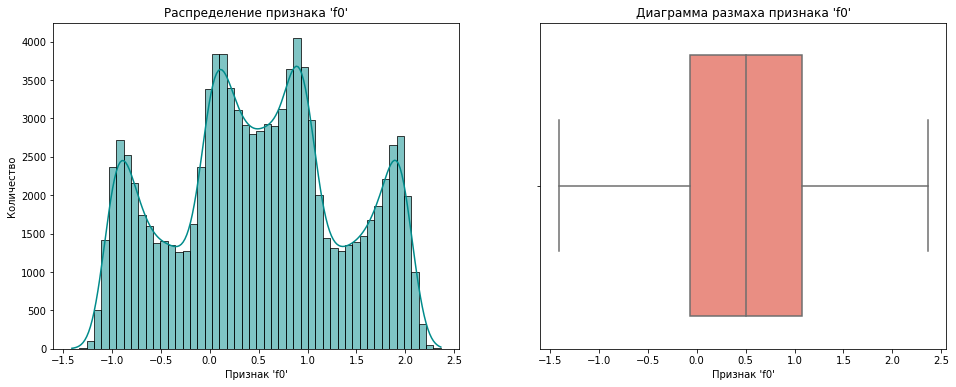

In [15]:
show_graph_1(
    geo_data_0,
    'f0',
    'Распределение признака '"'f0'"'',
    'Диаграмма размаха признака '"'f0'"'',
    'Признак '"'f0'"''
)

Распределение признака `f0` имеет четыре явно выраженных пика (значения около -1, 0.1, 0.9 и 1.9), выбросов и аномальных значений нет.

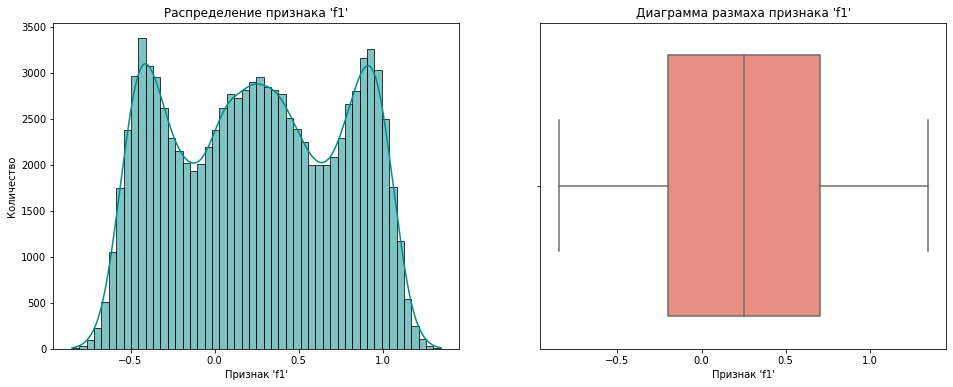

In [16]:
show_graph_1(
    geo_data_0,
    'f1',
    'Распределение признака '"'f1'"'',
    'Диаграмма размаха признака '"'f1'"'',
    'Признак '"'f1'"''
)

Распределение признака `f1` имеет три явно выраженных пика (значения около -0.4, 0.3 и 0.9), выбросов и аномальных значений нет.

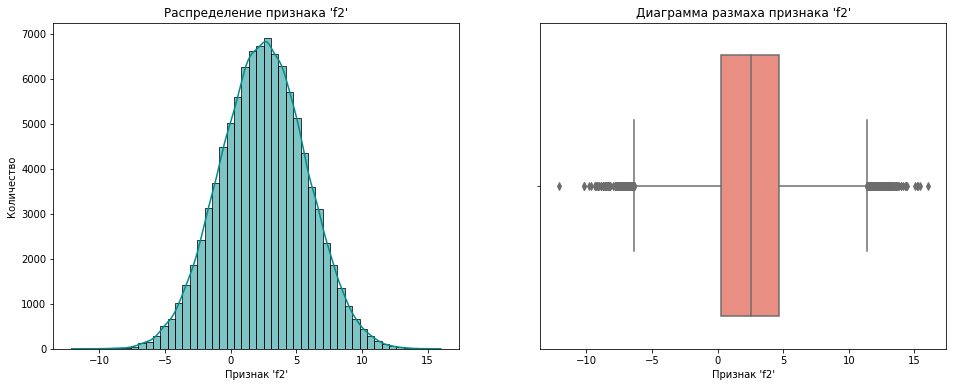

In [17]:
show_graph_1(
    geo_data_0,
    'f2',
    'Распределение признака '"'f2'"'',
    'Диаграмма размаха признака '"'f2'"'',
    'Признак '"'f2'"''
)

Распределение признака `f2` близко к нормальному, имеются аномальные значения.

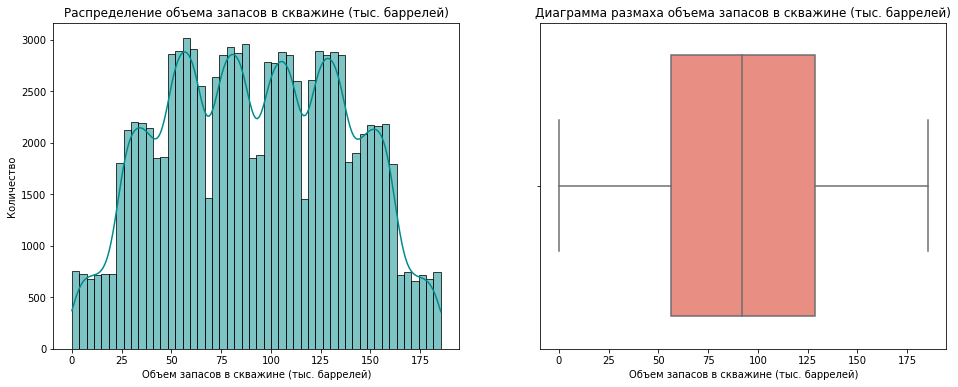

In [18]:
show_graph_1(
    geo_data_0,
    'product',
    'Распределение объема запасов в скважине (тыс. баррелей)',
    'Диаграмма размаха объема запасов в скважине (тыс. баррелей)',
    'Объем запасов в скважине (тыс. баррелей)'
)

Распределение объема запасов в скважине имеет шесть явно выраженных пиков (значения около 30, 60, 80, 110, 130 и 150), выбросов и аномальных значений нет.

Проверим, сколько в цевом столбце нулевых элементов (т.е. скважин, без запасов):

In [19]:
count = len(geo_data_0[geo_data_0['product'] == 0])
part = count / len(geo_data_0['product'])
print(f'Количество нулевых значений в целевом столбце - {count}')
print(f'Доля нулевых значений в целевом столбце - {part:.2%}')

Количество нулевых значений в целевом столбце - 1
Доля нулевых значений в целевом столбце - 0.00%


Доля нулевых значений в целевом столбце `product` незначительна.

#### Регион №2

Отобразим гистограмму и "ящик с усами" для столбцов `f0`, `f1`, `f2` и `product` датафрейма `geo_data_1`:

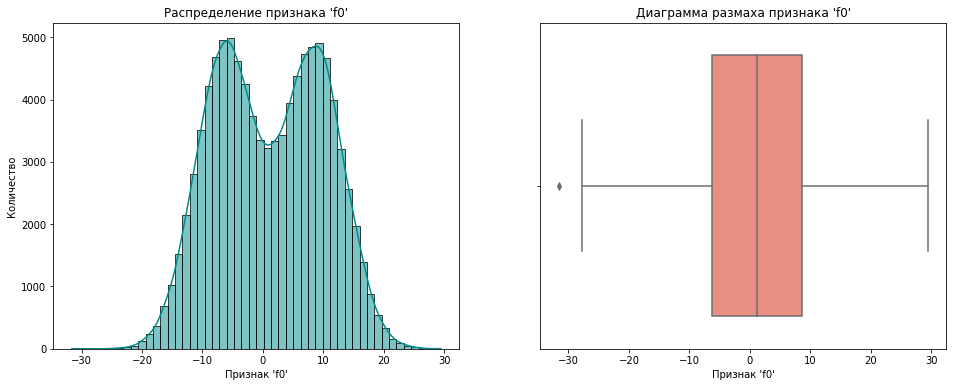

In [20]:
show_graph_1(
    geo_data_1,
    'f0',
    'Распределение признака '"'f0'"'',
    'Диаграмма размаха признака '"'f0'"'',
    'Признак '"'f0'"''
)

Распределение признака `f0` близко к нормльному, имеет два явно выраженных пика (значения около -6 и 9), имеются аномальные значения.

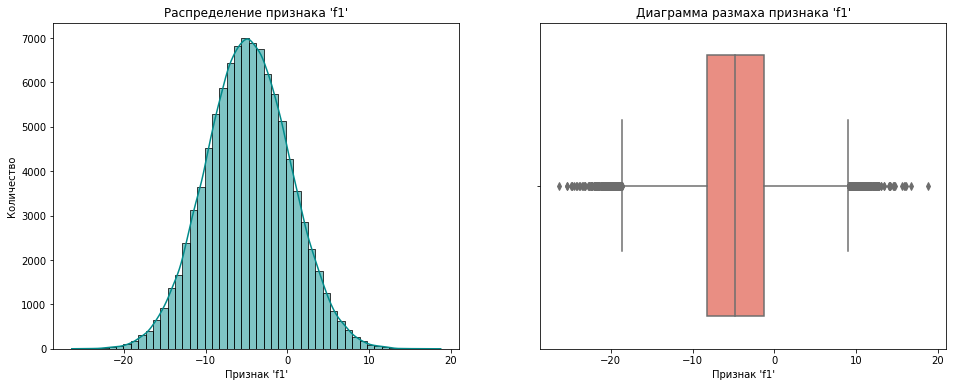

In [21]:
show_graph_1(
    geo_data_1,
    'f1',
    'Распределение признака '"'f1'"'',
    'Диаграмма размаха признака '"'f1'"'',
    'Признак '"'f1'"''
)

Распределение признака `f1` близко к нормльному, имеются аномальные значения.

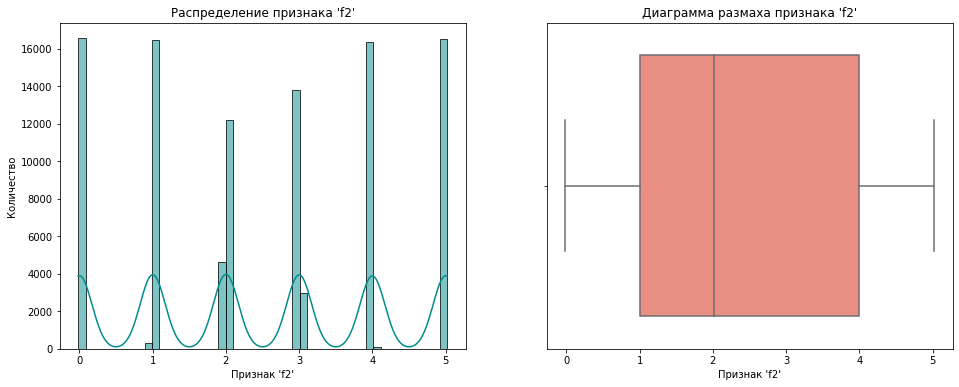

In [22]:
show_graph_1(
    geo_data_1,
    'f2',
    'Распределение признака '"'f2'"'',
    'Диаграмма размаха признака '"'f2'"'',
    'Признак '"'f2'"''
)

Судя по распределение признака `f2`, данный признак больше похоже на категориальный, нежели на количественный. Выбросов и аномальных значений нет.

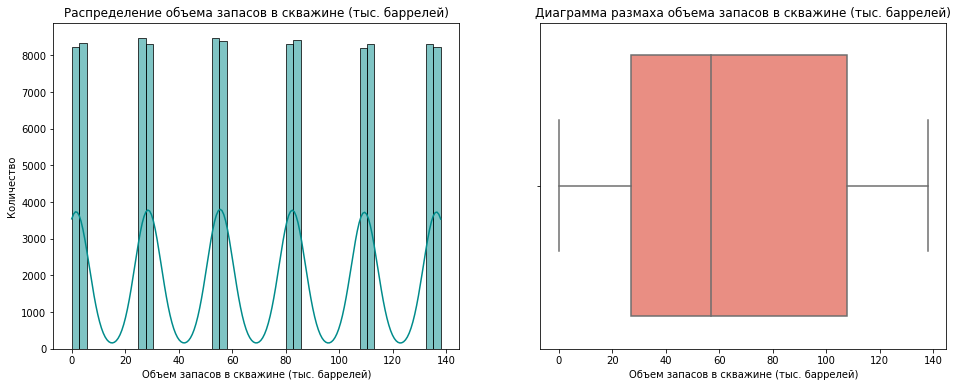

In [23]:
show_graph_1(
    geo_data_1,
    'product',
    'Распределение объема запасов в скважине (тыс. баррелей)',
    'Диаграмма размаха объема запасов в скважине (тыс. баррелей)',
    'Объем запасов в скважине (тыс. баррелей)'
)

Судя по распределение объема запасов в скважине, данный признак больше похоже на категориальный, нежели на количественный. Выбросов и аномальных значений нет.

Проверим, сколько в цевом столбце нулевых элементов (т.е. скважин, без запасов):

In [24]:
count = len(geo_data_1[geo_data_1['product'] == 0])
part = count / len(geo_data_1['product'])
print(f'Количество нулевых значений в целевом столбце - {count}')
print(f'Доля нулевых значений в целевом столбце - {part:.2%}')

Количество нулевых значений в целевом столбце - 8235
Доля нулевых значений в целевом столбце - 8.24%


Доля нулевых значений в целевом столбце `product` составляет 8.24% - довольно существенно, по сравнению с другими регионами.

#### Регион №3

Отобразим гистограмму и "ящик с усами" для столбцов `f0`, `f1`, `f2` и `product` датафрейма `geo_data_2`:

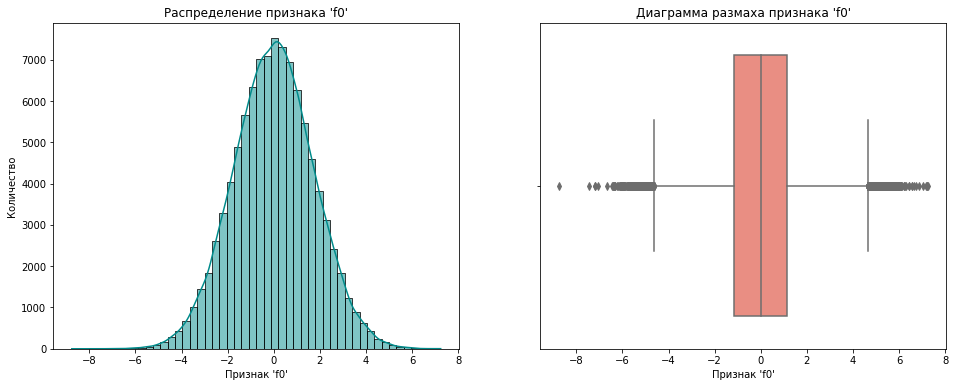

In [25]:
show_graph_1(
    geo_data_2,
    'f0',
    'Распределение признака '"'f0'"'',
    'Диаграмма размаха признака '"'f0'"'',
    'Признак '"'f0'"''
)

Распределение признака `f0` близко к нормльному, имеются аномальные значения.

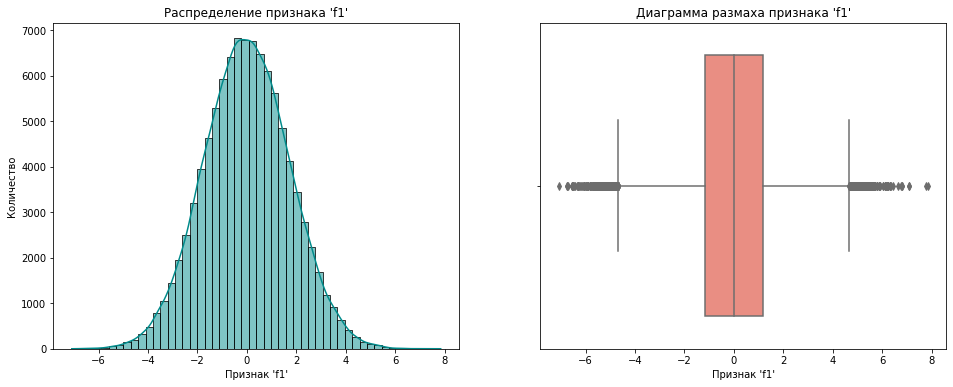

In [26]:
show_graph_1(
    geo_data_2,
    'f1',
    'Распределение признака '"'f1'"'',
    'Диаграмма размаха признака '"'f1'"'',
    'Признак '"'f1'"''
)

Распределение признака `f1` близко к нормльному, имеются аномальные значения.

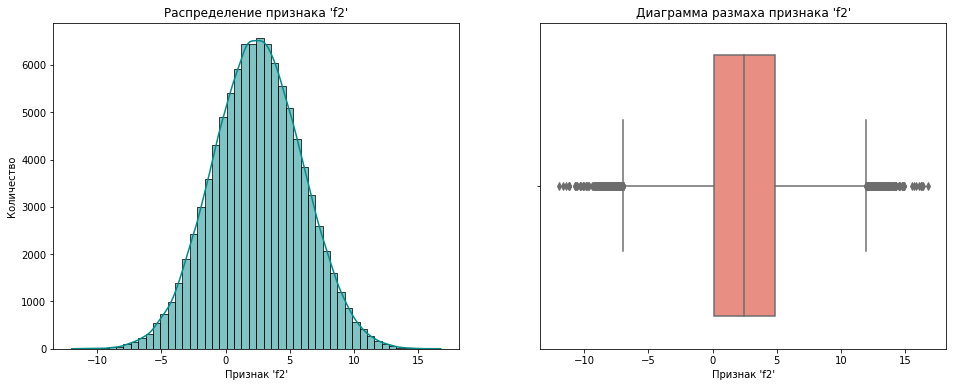

In [27]:
show_graph_1(
    geo_data_2,
    'f2',
    'Распределение признака '"'f2'"'',
    'Диаграмма размаха признака '"'f2'"'',
    'Признак '"'f2'"''
)

Распределение признака `f2` близко к нормльному, имеются аномальные значения.

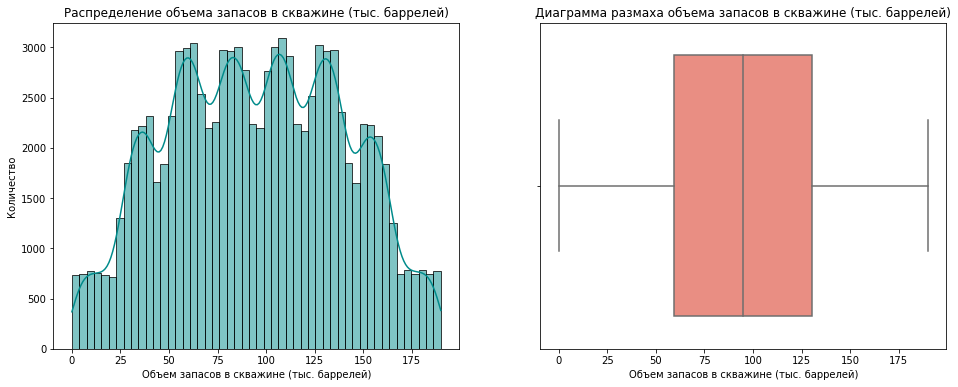

In [28]:
show_graph_1(
    geo_data_2,
    'product',
    'Распределение объема запасов в скважине (тыс. баррелей)',
    'Диаграмма размаха объема запасов в скважине (тыс. баррелей)',
    'Объем запасов в скважине (тыс. баррелей)'
)

Распределение объема запасов в скважине имеет шесть явно выраженных пиков (значения около 30, 60, 80, 110, 130 и 150), выбросов и аномальных значений нет.

Проверим, сколько в цевом столбце нулевых элементов (т.е. скважин, без запасов):

In [29]:
count = len(geo_data_2[geo_data_2['product'] == 0])
part = count / len(geo_data_2['product'])
print(f'Количество нулевых значений в целевом столбце - {count}')
print(f'Доля нулевых значений в целевом столбце - {part:.2%}')

Количество нулевых значений в целевом столбце - 1
Доля нулевых значений в целевом столбце - 0.00%


Доля нулевых значений в целевом столбце `product` незначительна.

#### Итог

Стоит отметить, что признак `f2` в датафрейме `geo_data_1` отличается от аналогичных признаков в других датафреймах - у него отличное от остальных распределение и порядок значений. Данные не подчиняются закону больших чисел и скорей всего были введены искуственно.

Кроме того, в датафрейме `geo_data_2` наблюдается большее число нулевых значений целевого признака, чем в других датафреймах. Можно сделать вывод о том, что, возможно, данные были утеряны или запас нефти в этих скважинах не был исследован.

Все эти факторы далее могут негативно сказаться на качестве и достоверности модели.

### Корреляционный анализ

Определим функцию для отображения тепловой карты корреляционной матрицы:

In [30]:
# категориальные и количественные признаки
def get_columns(df):
    return {
        'cat_col_names': df.select_dtypes(exclude='number').columns.tolist(),
        'num_col_names': df.select_dtypes(include='number').columns.tolist()
    }

In [31]:
def get_cm_plot(df, interval_cols=get_columns(df)['num_col_names']):
    phik_matrix = df.drop('id', axis=1).phik_matrix(interval_cols=interval_cols)
    plot_correlation_matrix(phik_matrix.values,
                        x_labels=phik_matrix.columns,
                        y_labels=phik_matrix.index,
                        vmin=0,
                        vmax=1,
                        color_map='Reds',
                        title=r'Тепловая карта корреляционной матрицы $\phi_K$',
                        fontsize_factor=1,
                        figsize=(8, 7),
                        identity_layout=False
                       )

Проведем корреляционный анализ признаков в количественной шкале в датафрейме для моделирования `geo_data_0`. Рассчитаем коэффициенты корреляции между всеми количественными признаками и отобразим матрицу корреляций с помощью тепловой карты:

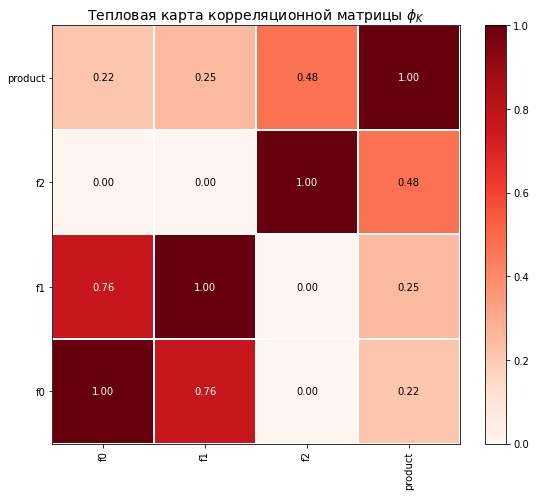

In [32]:
get_cm_plot(geo_data_0)

Темные тона тепловой карты говорят о сильной линейной зависимости, а светлые - о слабой. Судя по тепловой карте, самая сильная прямая связь с целевым признаком `product` у признака `f2`.

Мультиколлинеарность между признаками не обнаружена. Больше всех друг с другом коррелируют признаки `f0` и `f1`.

Проведем корреляционный анализ признаков в количественной шкале в датафрейме для моделирования `geo_data_1`. Рассчитаем коэффициенты корреляции между всеми количественными признаками и отобразим матрицу корреляций с помощью тепловой карты:

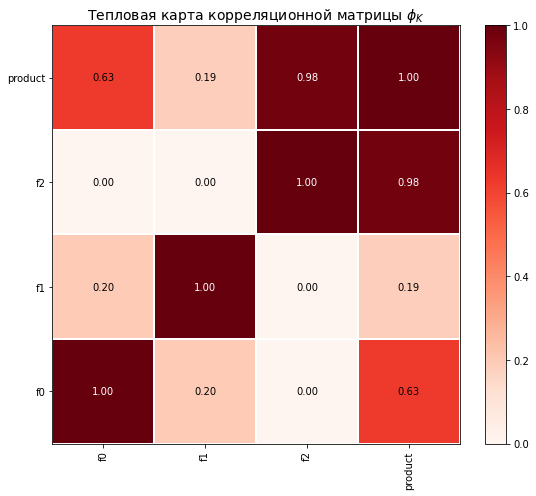

In [33]:
get_cm_plot(geo_data_1)

Судя по тепловой карте, самая сильная прямая связь с целевым признаком `product` у признаков `f0` и `f2`, при этом целевой признак слабо связан с признаком `f1`.

Мультиколлинеарность между признаками не обнаружена.

Проведем корреляционный анализ признаков в количественной шкале в датафрейме для моделирования `geo_data_2`. Рассчитаем коэффициенты корреляции между всеми количественными признаками и отобразим матрицу корреляций с помощью тепловой карты:

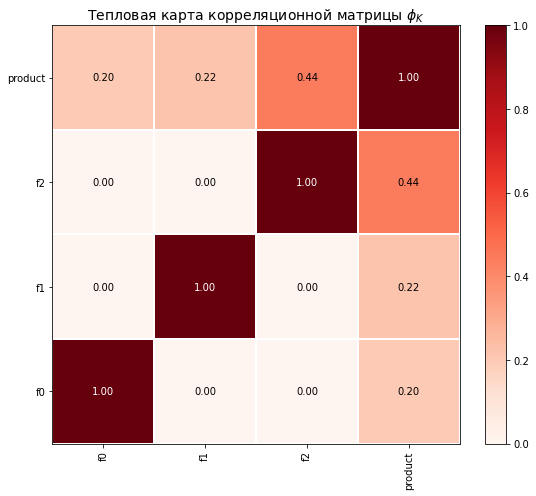

In [34]:
get_cm_plot(geo_data_2)

Судя по тепловой карте, самая сильная прямая связь с целевым признаком `product` у признака `f2`.

Мультиколлинеарность между признаками не обнаружена.

## Обучение и проверка модели

В условиях задачи значилось, что для обучения модели подходит только линейная регрессия, т.к. остальные модели дают недостаточно предсказуемые результаты, поэтому будем использовать модель `LinearRegression()`.

Определим переменные:

In [35]:
RANDOM_STATE = 42
test_size=0.25

Определим функцию для подготовки данных:

In [36]:
def prepare_data(df):
    # делим датасет на выборки
    X = df.drop(['id', 'product'], axis=1)
    y = df['product']

    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        y,
        random_state=RANDOM_STATE,
        test_size=test_size
    )

    # список с количественными признаками
    num_col_names = get_columns(X_train)['num_col_names']

    # класс StandardScaler() для масштабирования 
    scaler = StandardScaler()

    # масштабирование количественных признаков из тренировочной и валидационной выборок
    X_train = scaler.fit_transform(X_train[num_col_names])
    X_valid = scaler.transform(X_valid[num_col_names])
    X_train = pd.DataFrame(X_train, columns=num_col_names)
    X_valid = pd.DataFrame(X_valid, columns=num_col_names)
    
    return X_train, X_valid, y_train, y_valid

### Регион №1

Подготовим для модели данные по первому региону:

In [37]:
X_train_0, X_valid_0, y_train_0, y_valid_0 = prepare_data(geo_data_0)

Оценим RMSE первой модели на кросс-валидации:

In [38]:
model_0 = LinearRegression()
result_0 = cross_val_score(model_0, X_train_0, y_train_0, cv=5, scoring='neg_root_mean_squared_error')
print(f'RMSE модели №1 на кросс-валидации: {(-1) * result_0.mean()}')

RMSE модели №1 на кросс-валидации: 37.67200536313506


Обучим первую модель и сделаем предсказания на валидационной выборке, выведем средний запас предсказанного сырья и RMSE модели:

In [39]:
model_0.fit(X_train_0, y_train_0)
predicted_0 = model_0.predict(X_valid_0)
print(f'Средний запас сырья в первом регионе: {predicted_0.mean()}')
print(f'RMSE модели №1: {mean_squared_error(y_valid_0, predicted_0, squared=False)}')

Средний запас сырья в первом регионе: 92.39879990657768
RMSE модели №1: 37.75660035026169


Для первого региона в среднем объем запасов в скважине отличается от фактического значения на ±37.76 тыс. баррелей.

Сохраним предсказания и правильные ответы на валидационной выборке:

In [40]:
model_data_0 = pd.DataFrame({
    'product_true': y_valid_0,
    'product_pred': predicted_0
}).join(geo_data_0).drop(['product', 'f0', 'f1', 'f2'], axis=1).reindex(columns=['id', 'product_true', 'product_pred'])

### Регион №2

Подготовим для модели данные по второму региону:

In [41]:
X_train_1, X_valid_1, y_train_1, y_valid_1 = prepare_data(geo_data_1)

Оценим RMSE второй модели на кросс-валидации:

In [42]:
model_1 = LinearRegression()
result_1 = cross_val_score(model_1, X_train_1, y_train_1, cv=5, scoring='neg_root_mean_squared_error')
print(f'RMSE модели №2 на кросс-валидации: {(-1) * result_1.mean()}')

RMSE модели №2 на кросс-валидации: 0.8904559629285673


Обучим вторую модель и сделаем предсказания на валидационной выборке, выведем средний запас предсказанного сырья и RMSE модели:

In [43]:
model_1.fit(X_train_1, y_train_1)
predicted_1 = model_1.predict(X_valid_1)
print(f'Средний запас сырья во втором регионе: {predicted_1.mean()}')
print(f'RMSE модели №2: {mean_squared_error(y_valid_1, predicted_1, squared=False)}')

Средний запас сырья во втором регионе: 68.7128780391376
RMSE модели №2: 0.8902801001028846


Для второго региона в среднем объем запасов в скважине отличается от фактического значения на ±0.89 тыс. баррелей.

Сохраним предсказания и правильные ответы на валидационной выборке:

In [44]:
model_data_1 = pd.DataFrame({
    'product_true': y_valid_1,
    'product_pred': predicted_1
}).join(geo_data_1).drop(['product', 'f0', 'f1', 'f2'], axis=1).reindex(columns=['id', 'product_true', 'product_pred'])

### Регион №3

Подготовим для модели данные по третьему региону:

In [45]:
X_train_2, X_valid_2, y_train_2, y_valid_2 = prepare_data(geo_data_2)

Оценим RMSE третьей модели на кросс-валидации:

In [46]:
model_2 = LinearRegression()
result_2 = cross_val_score(model_2, X_train_2, y_train_2, cv=5, scoring='neg_root_mean_squared_error')
print(f'RMSE модели №3 на кросс-валидации: {(-1) * result_2.mean()}')

RMSE модели №3 на кросс-валидации: 40.02698159997838


Обучим третью модель и сделаем предсказания на валидационной выборке, выведем средний запас предсказанного сырья и RMSE модели:

In [47]:
model_2.fit(X_train_2, y_train_2)
predicted_2 = model_2.predict(X_valid_2)
print(f'Средний запас сырья в третьем регионе: {predicted_2.mean()}')
print(f'RMSE модели №3: {mean_squared_error(y_valid_2, predicted_2, squared=False)}')

Средний запас сырья в третьем регионе: 94.77102387765939
RMSE модели №3: 40.145872311342174


Для третьего региона в среднем объем запасов в скважине отличается от фактического значения на ±40.15 тыс. баррелей.

Сохраним предсказания и правильные ответы на валидационной выборке:

In [48]:
model_data_2 = pd.DataFrame({
    'product_true': y_valid_2,
    'product_pred': predicted_2
}).join(geo_data_2).drop(['product', 'f0', 'f1', 'f2'], axis=1).reindex(columns=['id', 'product_true', 'product_pred'])

### Итог

Наибольший средний запас предсказанного сырья у третьего региона (94.77 тыс. баррелей). На втором по данному показателю - первый регион (92.4 тыс. баррелей). Наименьшие средние запасы у первого региона (68.71 тыс. баррелей).

Точность работы модели выше у второго региона (метрика RMSE составила 0.89 тыс. баррелей). Для других регионов точность значительно ниже: для первого региона метрика RMSE составила 37.76 тыс. баррелей, а для третьего региона - 40.15 тыс. баррелей.

## Подготовка к расчету прибыли

Определим переменные экономической информации из условий задачи:

In [49]:
budget = 10**10
select_oilwell_count = 500
best_oilwell_count = 200
barrel_profit = 450

Рассчитаем минимальную среднюю стоимость нефти в месторождениях региона, достаточную для разработки:

In [50]:
min_money_oilwell = budget / best_oilwell_count
min_money_oilwell

50000000.0

Для того, чтобы без убытка добыть нефть в регионе, необходимо, чтобы 200 скважин принесли 50 млн рублей дохода.

Рассчитаем достаточный объем сырья для безубыточной разработки новой скважины:

In [51]:
min_count_oil = min_money_oilwell / barrel_profit / 1000
min_count_oil

111.11111111111111

Таким образом, для безубыточной добычи необходимо, чтобы каждая скважина в среднем содержала не менее 111 тыс. баррелей нефти.

Сравним полученный объем сырья со средним запасом в каждом регионе:

In [52]:
compare_table = pd.DataFrame({
    'Регион': [1, 2, 3],
    'Средний запас сырья': [predicted_0.mean(), predicted_1.mean(), predicted_2.mean()],
    'Объем сырья для безубыточной добычи': 3 * [min_count_oil]
})
compare_table['Разница'] = compare_table['Средний запас сырья'] - compare_table['Объем сырья для безубыточной добычи']
compare_table

,Регион,Средний запас сырья,Объем сырья для безубыточной добычи,Разница
0,1,92.398800,111.111111,-18.712311
1,2,68.712878,111.111111,-42.398233
2,3,94.771024,111.111111,-16.340087


Получается, что каждый регион является убыточным в плане добычи нефти (если задейстововать все скважины в каждом регионе), причем величина убытка самая большая во втором регионе. Для того, чтобы добыча сырья была прибыльной, необходимо в каждом регионе выбрать лучшие по количеству нефти 200 скважин.

## Расчет прибыли и рисков

Рассчитаем прибыль по регионам:
* Выберем скважины с максимальными значениями предсказаний
* Просуммируем целевое значение объема сырья, соответствующее этим предсказаниям
* Рассчитаем прибыль для полученного объема сырья

Для этой цели определим функцию:

In [53]:
def get_profit(data, max_count, unit_profit, cost):
    return data.sort_values(
        by='product_pred',
        ascending=False
    ).head(max_count)['product_true'].sum() * unit_profit * 1000 - cost

Определим функцию для форматирования чисел:

In [54]:
def ch_format(ch):
    return '{0:,}'.format(int(round(ch, 0))).replace(',', ' ')

Рассчитаем прибыль по каждому региону на основе 200 лучших скважин:

In [55]:
k = 1
for i in [model_data_0, model_data_1, model_data_2]:
    profit = get_profit(i, best_oilwell_count, barrel_profit, budget)
    print('Прибыль от добычи сырья в регионе', k, '->', ch_format(profit), 'руб.')
    k += 1

Прибыль от добычи сырья в регионе 1 -> 3 359 141 114 руб.
Прибыль от добычи сырья в регионе 2 -> 2 415 086 697 руб.
Прибыль от добычи сырья в регионе 3 -> 2 598 571 759 руб.


Наибольшую прибыль от добычи нефти можно получить в первом регионе. Меньше всего прибыли можно получить, добывая нефть во втором регионе.

Применим технику Bootstrap с 1000 выборок, чтобы найти среднюю прибыль, 95%-й доверительный интервал и риск убытков. Для подсчета этих показателей определим функцию:

In [56]:
def get_bootstrap_data(data, count):
    state = np.random.RandomState(12345)
    profit_values = []
    n = 1000
    for i in range(n):
        subsample = data.sample(n=count, replace=False, random_state=state)
        profit_values.append(get_profit(subsample, best_oilwell_count, barrel_profit, budget))
    profit_values = pd.Series(profit_values)
    confidence_interval = (profit_values.quantile(0.025), profit_values.quantile(0.975))
    risk = len(profit_values[profit_values < 0]) / n
    return profit_values, profit_values.mean(), confidence_interval, risk

Определим функцию для построения гистограммы и доверительных интервалов:

In [57]:
def show_graph_2(data, hist_title, xlabel, confidence_interval):
    plt.figure(figsize=(14, 7))
    histplot = sns.histplot(
        data=data,
        bins=50,
        color='darkcyan',
        kde=True
    )
    histplot.set(
        title=hist_title,
        xlabel=xlabel,
        ylabel='Количество'
    )
    plt.axvline(
        x=confidence_interval[0],
        color='b',
        ymax=0.95,
        linestyle='--'
    )
    plt.axvline(
        x=confidence_interval[1],
        color='r',
        ymax=0.95,
        linestyle='--'
    )
    plt.legend(
        title='',
        loc='upper right',
        labels=['Прибыль', 'Нижняя граница\nдоверит. интервала', 'Верхняя граница\nдоверит. интервала']
    )

Далее рассчитаем указанные выше показатели для каждого региона.

### Регион №1

Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для первого региона:

In [58]:
profit_values_0, profit_0, confidence_interval_0, risk_0 = get_bootstrap_data(model_data_0, select_oilwell_count)
print(f'Средняя прибыль -> {ch_format(profit_0)} руб.')
print(f'95%-й доверительный интервал -> ({ch_format(confidence_interval_0[0])}, {ch_format(confidence_interval_0[1])})')
print(f'Риск -> {risk_0:.2%}')

Средняя прибыль -> 406 007 068 руб.
95%-й доверительный интервал -> (-122 700 688, 897 180 546)
Риск -> 5.70%


Построим гистограмму для отображения распределения прибыли от добычи нефти:

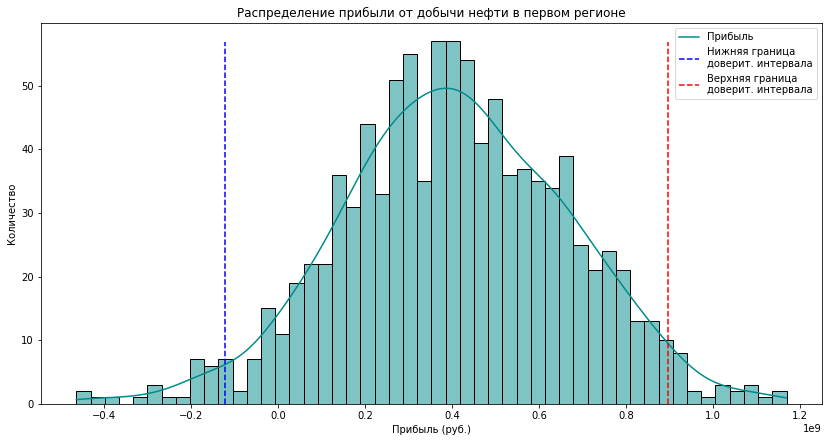

In [59]:
show_graph_2(
    profit_values_0,
    'Распределение прибыли от добычи нефти в первом регионе',
    'Прибыль (руб.)',
    confidence_interval_0
)

Добыча нефти в скважинах первого региона в среднем даст 406 млн руб. прибыли при риске 5.7%.

### Регион №2

Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для второго региона:

In [60]:
profit_values_1, profit_1, confidence_interval_1, risk_1 = get_bootstrap_data(model_data_1, select_oilwell_count)
print(f'Средняя прибыль -> {ch_format(profit_1)} руб.')
print(f'95%-й доверительный интервал -> ({ch_format(confidence_interval_1[0])}, {ch_format(confidence_interval_1[1])})')
print(f'Риск -> {risk_1:.2%}')

Средняя прибыль -> 442 436 902 руб.
95%-й доверительный интервал -> (28 958 037, 834 438 102)
Риск -> 1.90%


Построим гистограмму для отображения распределения прибыли от добычи нефти:

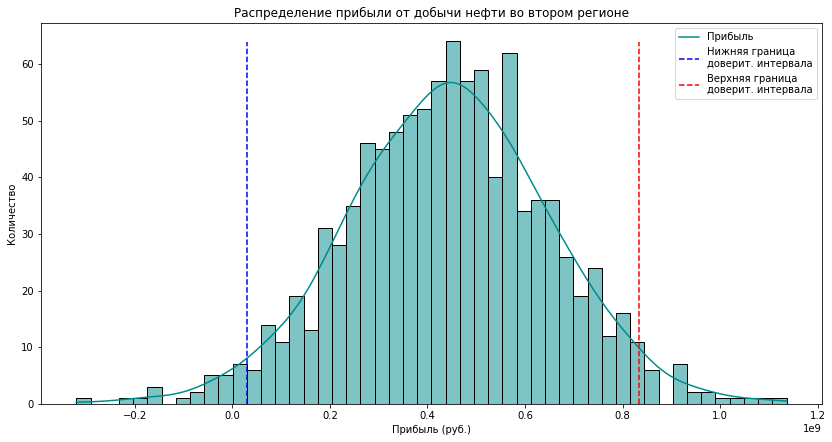

In [61]:
show_graph_2(
    profit_values_1,
    'Распределение прибыли от добычи нефти во втором регионе',
    'Прибыль (руб.)',
    confidence_interval_1
)

Добыча нефти в скважинах второго региона в среднем даст 442 млн руб. прибыли при риске 1.9%.

### Регион №3

Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для третьего региона:

In [62]:
profit_values_2, profit_2, confidence_interval_2, risk_2 = get_bootstrap_data(model_data_2, select_oilwell_count)
print(f'Средняя прибыль -> {ch_format(profit_2)} руб.')
print(f'95%-й доверительный интервал -> ({ch_format(confidence_interval_2[0])}, {ch_format(confidence_interval_2[1])})')
print(f'Риск -> {risk_2:.2%}')

Средняя прибыль -> 367 919 519 руб.
95%-й доверительный интервал -> (-116 746 476, 880 262 773)
Риск -> 8.80%


Построим гистограмму для отображения распределения прибыли от добычи нефти:

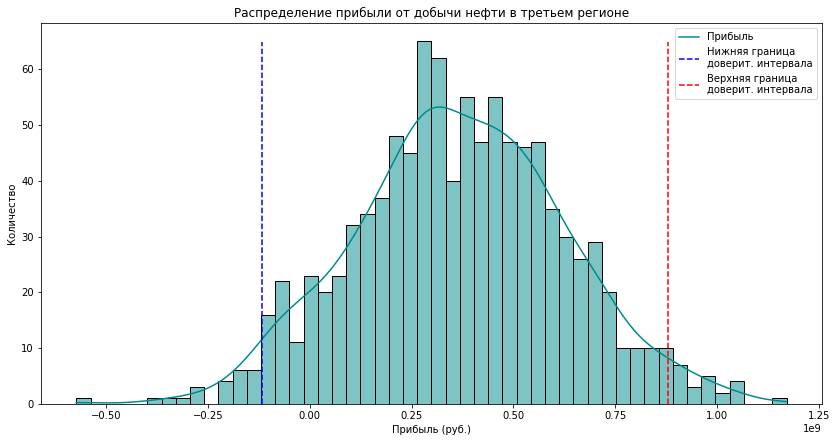

In [63]:
show_graph_2(
    profit_values_2,
    'Распределение прибыли от добычи нефти в третьем регионе',
    'Прибыль (руб.)',
    confidence_interval_2
)

Добыча нефти в скважинах третьего региона в среднем даст 368 млн руб. прибыли при риске 8.8%.

### Итог

Построим гистограмму для отображения распределения прибыли от добычи нефти во всех регионах:

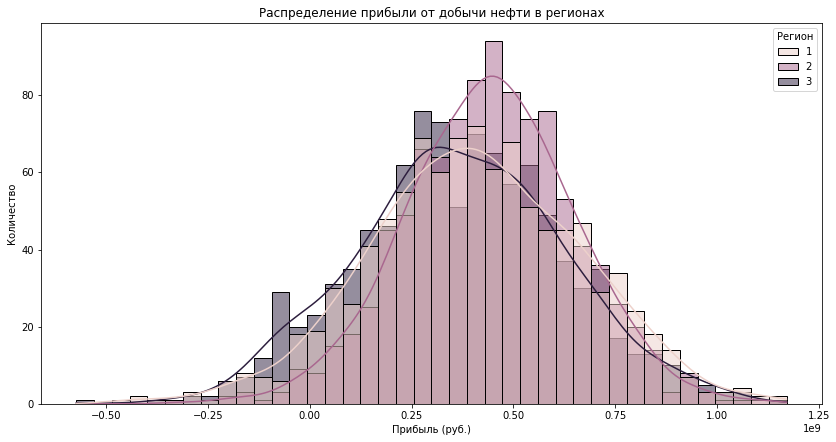

In [64]:
regions_profit = pd.concat([
    pd.DataFrame({
        'Прибыль': profit_values_0,
        'Регион': len(profit_values_0) * [1]
    }),
    pd.DataFrame({
        'Прибыль': profit_values_1,
        'Регион': len(profit_values_1) * [2]
    }),
    pd.DataFrame({
        'Прибыль': profit_values_2,
        'Регион': len(profit_values_0) * [3]
    })
])

plt.figure(figsize=(14, 7))
histplot = sns.histplot(
    data=regions_profit,
    x='Прибыль',
    hue='Регион',
    kde=True
)
histplot.set(
    title='Распределение прибыли от добычи нефти в регионах',
    xlabel='Прибыль (руб.)',
    ylabel='Количество'
);

По условию задачи для добычи нефти подходит тот регион, где вероятность убытков меньше 2.5% и в котором наибольшая средняя прибыль среди остальных регионов. По уровню риска в норматив укладывается только второй регион, в нем же достигается и наибольшая прибыль, поэтому данный регион стоит выбрать для добычи нефти.

## Итоговые выводы

В рамках исследования было необходимо проанализировать данные, предоставленные добывающей компанией «ГлавРосГосНефть» с характеристиками скважин в трех регионах. Цель бизнеса - избежать финансовых потерь и рисков при выобре региона, бурить новую скважину и добывать сырье.

В рамках исследования было необходимо решить две задачи:
* Построить модель машинного обучения, которая поможет определить регион, где добыча принесет наибольшую прибыль
* Проанализировать возможные прибыль и риски по регионам с помощью техники *Bootstrap*

В ходе исследования при решении данных задач были реализованы следующие этапы:
* Загрузка и предобработка данных
* Исследовательский анализ данных
* Корреляционный анализ
* Подготовка данных и обучение моделей
* Расчет прибыли и рисков

Опираясь на условия выбора региона, предоставленные бизнесом, и на результаты исследования, добывающей компании «ГлавРосГосНефть» из трех представленных регионов для добычи сырья стоит выбрать второй, т.к. в данном регионе выше средняя прибыль от добычи нефти и самые низкие риски.